<a href="https://colab.research.google.com/github/GabrielaMihoci/ProiectProgramareProcedurala/blob/master/Copy_of_TF_SB_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Machine Learning and TensorFlow

This workshop intends to provide you with a simple introduction to ML, starting from basic principles. We will start using TensorFlow (TF), after a short general introduction.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline

tf.__version__

'2.3.0'

## Linear Regression

Regressions are foundational to machine learning. The simplest model is one that models a **linear** relationship between a **scalar** output variable and one ore more explanatory variables.

### Linear Regression in 1D

The simplest machine learning task is trying to build a model of form

$$y = a x + b$$

where $x$ and $y$ are given by the dataset and $a$ and $b$ must be learned from the model.

#### Train Problem

To exemplify, consider this classic Physics problem:

_You are in a train going from city A to city B. Your phone's GPS can tell you the distance from city A at every moment in time. Knowing time $t$ and distance $x$, what is the speed of the train?_

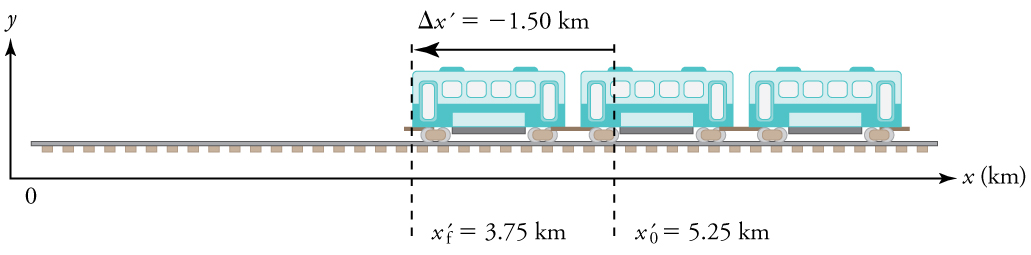

From Physics, we know that $x = v * t$ where $v$ is the velocity we are interested in. So, one quick way to solve this is to do a single measurement of distance $x$ at a time $t$ and then divide these two quantities.

However, this approach fails to consider these important aspects:
* measurements (both time and space) are erroneous
* train speed might not be perfectly constant

Hence, we will take multiple measurements, and record a set of $(p, t)$ pairs into a dataset (using $p$ for position as we'll use $x$, $y$ in general ML tasks):

In [ ]:
def generate_train_dataset(num_samples=100, seed=42, target_v=10, scale_t=0.1, scale_p=10):
  """Return a dataset of (position, time) tuples for train problem."""
  np.random.seed(seed)
  ts = np.linspace(0, num_samples, num_samples)
  ps = target_v * ts

  # Add some measurement noise
  ts += np.random.normal(scale=scale_t, size=num_samples)
  ps += np.random.normal(scale=scale_p, size=num_samples)

  return (ts, ps)

Suppose we are taking 100 measurements. 

In [ ]:
num_samples = 100
ts, ps = generate_train_dataset(num_samples=num_samples)
pd.DataFrame({"time":ts, "position":ps})

,time,position
0,0.049671,-14.153707
1,0.996275,5.894557
2,2.084971,16.774875
3,3.182606,22.280258
4,4.016989,38.791183
...,...,...
95,95.813244,963.449133
96,96.999309,960.858395
97,98.005904,981.335231
98,98.990410,990.481077


First thing to do is to plot these to see if we have a linear relationship:

Text(0, 0.5, 'position')

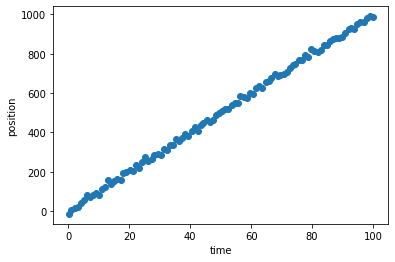

In [ ]:
plt.scatter(ts, ps)
plt.xlabel('time')
plt.ylabel('position')

We can compute speed using the naive formula at a few measurement points:

In [ ]:
measurements=10
mts = []
mps = []
mss = []
for ix in range(0, num_samples, num_samples//measurements):
  mts.append(ts[ix])
  mps.append(ps[ix])
  mss.append(ps[ix] / ts[ix])

pd.DataFrame({"time":mts, "position":mps, "speed":mss})

,time,position,speed
0,0.049671,-14.153707,-284.946731
1,10.054668,81.822389,8.137751
2,20.348585,209.930521,10.316713
3,30.242860,287.523669,9.507159
4,40.477887,406.315003,10.037950
5,50.537459,507.555434,10.043153
6,60.558143,596.313789,9.846963
7,70.743210,698.175563,9.869153
8,80.786114,814.337482,10.080167
9,90.918799,904.625760,9.949821


#### Solving the train problem with ML

As we see, the speeds obtained with the naive methods are not consistent, although they hover around the real speed.

Let's try now to use a linear regression model:

$$y = w * x + b$$

where:

* $y$ is the outcome variable (in our case, the measured position),
* $x$ is the independent variable (in our case, the time),
* $w$ is a slope parameter, a **weight** for $x$,
* $b$ is the intercept, a **bias** term

**In this model, $x$ and $y$ are "fixed": they are given by the data that we have obtained. We are interested in learning $w$ and $b$.**

Let's first assume we have a "guess" for $w$ and $b$ and try to plot the data given by this guess:

In [ ]:
def predict_train_position(w, b, t):
  """Returns the x position for t, given guess (w, b)."""
  return w * t + b

Lets plot the outcome, with a guess taken from the naive output:

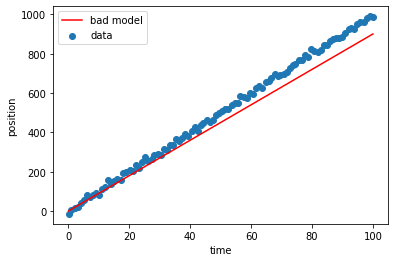

In [ ]:
w_guess = 9
b_guess = 0.5
predicted_ps = predict_train_position(w_guess, b_guess, ts)

plt.scatter(ts, ps, label="data")
plt.plot(ts, predicted_ps, color="red", label="bad model")
plt.xlabel('time')
plt.ylabel('position')
plt.legend()

##### How bad is the model?

To measure the _utility_ of the model, we use a **loss** quantity: it tells us how far apart the prediction is from the data, at the measurement points.

**Note**: Talk about loss functions and metrics (distances).

Usually, for linear regression models, we use the **mean squared error** (MSE) loss: the average of the sum of errors. There are other loss functions used in ML, but this one is the best for linear regression.

$$\mathcal{L} = \frac{1}{2n}\sum_{i=0}^{n}{(y_{pred} - y_{real})^2}$$

**Exercise**: Implement MSE

In [ ]:
def mse_loss(y_pred, y_real):
  delta = y_pred - y_real
  return np.average(delta * delta) / 2

Use the following cell to validate implementation:

In [ ]:
def check_mse_loss(y_pred, y_real, mse_expected):
  print(f"Testing mse_loss({y_pred}, {y_real}), expecting {mse_expected:.2f}: ", end='')
  try:
    mse_obtained = mse_loss(y_pred, y_real)
  except Exception as e:
    print(f"EXCEPTION: {e}")
  else:
    if np.abs(mse_obtained - mse_expected) < 0.01:
      print("PASS")
    else:
      print("FAIL")

check_mse_loss(np.array([1,1,1]), np.array([1,1,1]), 0)
check_mse_loss(np.array([1,1,1]), np.array([1,0,2]), 1/3)
check_mse_loss(np.array([1,2,3]), np.array([3,2,1]), 4/3)

Testing mse_loss([1 1 1], [1 1 1]), expecting 0.00: PASS
Testing mse_loss([1 1 1], [1 0 2]), expecting 0.33: PASS
Testing mse_loss([1 2 3], [3 2 1]), expecting 1.33: PASS


We should obtain a MSE score of 1712 in our scenario

In [ ]:
try:
  print(mse_loss(ps, predicted_ps))
except Exception as e:
  print(f"EXCEPTION: {e}")
  print(f"Did you solve exercise?")

1712.9887453825943


##### How do we get a better model?

We can try to guess a better $(w, b)$ pair or we can use math to determine it using **gradient descent**.

Gradient descent involves computing the gradient of the loss function given our data points. Then, we move $(w, b)$ in the opposite direction of the gradient, to minimize the loss.

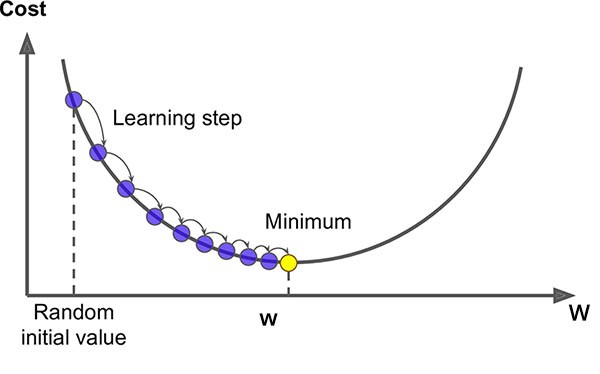


Given $\mathcal{L}$ and the linear regression formula, we can replace $y_{pred}$ in the loss formula and then compute the partial derivatives and the gradient:


$$\mathcal{L} = \frac{1}{2n}\sum_{i=0}^{n}{(w * x_i + b - y_i)^2}$$

$$\frac{\partial\mathcal{L}}{\partial{w}} = \frac{1}{n}\sum_{i=0}^{n}{x_i(w * x_i + b - y_i)}$$
$$\frac{\partial\mathcal{L}}{\partial{b}} = \frac{1}{n}\sum_{i=0}^{n}{(w * x_i + b - y_i)}$$

$$\nabla\mathcal{L} = \left(\frac{\partial\mathcal{L}}{\partial{w}}, \frac{\partial\mathcal{L}}{\partial{b}}\right)$$

Then, we can update our parameters, using a learning rate $\alpha$ (learning step):

$$w \leftarrow w - \alpha * \frac{\partial\mathcal{L}}{\partial{w}} $$
$$b \leftarrow b - \alpha * \frac{\partial\mathcal{L}}{\partial{b}} $$

We repeat these update steps until the loss function reaches a minimum or a certain number of iterations is achieved.

**Note**: Discuss why learning rate is needed

**Homework**:

1. Implement a function `grad_loss` that returns the two partial derivatives
2. Implement a function `update_step` that updates $(w, b)$ based on gradient and learning rate
3. Implement a gradient descent loop

Solution: next week

**Note**: Discuss about downsides of full gradient descent. Introduce SGD.

#### Solving the train problem with TensorFlow

Writing the gradient computations and the training loop by hand is a repetitive task. Instead, let's use TensorFlow to do the training for us.

TensorFlow is known as a framework for (deep) neural networks. A neural network is a graph of "neurons", small computational units.

A simple neuron has a number of inputs and an output. The output is computed as a function of the weighted sum of inputs and an optional bias:

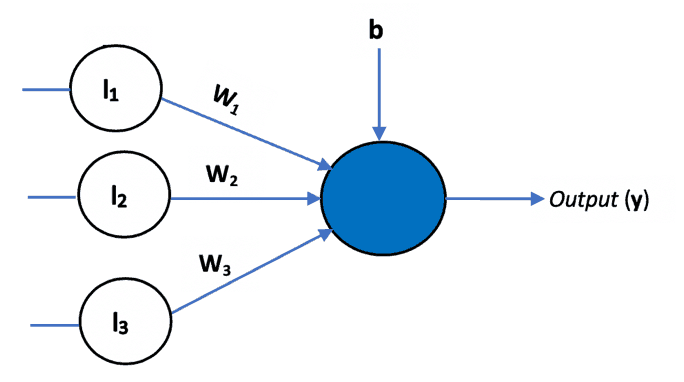

That is, 

$$y = f(\sum_{i}{w_i * x_i} + b)$$

where

* $f$ is the **activation** function,
* $x_i$ are the inputs of the neuron,
* $b$ is the bias
* $y$ is the output of the neuron

Let's consider the case with a single input and taking $f$ to be the **identity** activation:

$$y = w*x + b$$

But this is exactly the linear regression formulation.

**Linear regression is equivalent to a neuron with a single input and identity activation function**.

So, let's build a TensorFlow model with a single neuron, with a single input:

In [ ]:
def build_train_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(1, activation="linear", input_shape=(1,))
    ])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mse")
  model.summary()
  return model

**Note**: discuss optimizer and input shape

In [ ]:
model = build_train_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


**Note**: discuss summary output

Next, we train the model:

In [ ]:
hist = model.fit(ts, ps, epochs=200)

Epoch 1/200
4/4 [==============================] - 0s 2ms/step - loss: 225462.5781
Epoch 2/200
4/4 [==============================] - 0s 2ms/step - loss: 203945.2031
Epoch 3/200
4/4 [==============================] - 0s 2ms/step - loss: 183686.5625
Epoch 4/200
4/4 [==============================] - 0s 1ms/step - loss: 164860.2031
Epoch 5/200
4/4 [==============================] - 0s 2ms/step - loss: 146990.7656
Epoch 6/200
4/4 [==============================] - 0s 2ms/step - loss: 130324.3594
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 115551.8984
Epoch 8/200
4/4 [==============================] - 0s 2ms/step - loss: 101610.2109
Epoch 9/200
4/4 [==============================] - 0s 1ms/step - loss: 89487.6797
Epoch 10/200
4/4 [==============================] - 0s 2ms/step - loss: 77863.2891
Epoch 11/200
4/4 [==============================] - 0s 1ms/step - loss: 67117.5312
Epoch 12/200
4/4 [==============================] - 0s 1ms/step - loss: 58337.0742
Epoch

And now we can make some predictions and plot the output:

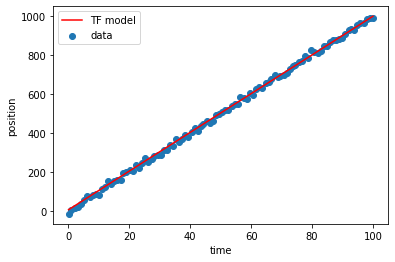

In [ ]:
predicted_ps = model.predict(ts)

plt.scatter(ts, ps, label="data")
plt.plot(ts, predicted_ps, color="red", label="TF model")
plt.xlabel('time')
plt.ylabel('position')
plt.legend()

Since we saved the training history, we can analyze it, plotting the loss at each epoch:

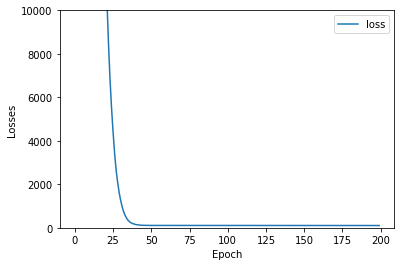

In [ ]:
def plot_training_history(hist):
  plt.plot(hist.history['loss'], label='loss')
  plt.ylim([0, 10000])
  plt.xlabel('Epoch')
  plt.ylabel('Losses')
  plt.legend()

plot_training_history(hist)

## Linear Regression in multiple dimensions

Now that we have a simple TF model for a toy 1D regression, let's take a real problem which can be solved with linear regression.

#### The Auto MPG dataset

In this scenario, we want to predict gas efficiency of a car (MPG).

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

Hence, we begin by downloading the data:[link text](https://)

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [ ]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [ ]:
def build_full_normalizer(based_on):
  data = np.array(based_on)
  normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
  normalizer.adapt(data)
  return normalizer

normalizer = build_full_normalizer(train_xs)

InvalidArgumentError: ignored

The CSV containing the dataset has a few missing values (N/A) so we will eliminate them:

In [ ]:
dataset = dataset.dropna()

Next, since the "Origin" field is actually an index into a set (i.e. **categorical data**), we use **one-hot encoding** to decode that to the countries:

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.sample(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
292,18.5,8,360.0,150.0,3940.0,13.0,79,0,0,1
334,23.7,3,70.0,100.0,2420.0,12.5,80,0,1,0
229,16.0,8,400.0,180.0,4220.0,11.1,77,0,0,1
149,24.0,4,120.0,97.0,2489.0,15.0,74,0,1,0
160,17.0,6,231.0,110.0,3907.0,21.0,75,0,0,1
236,25.5,4,140.0,89.0,2755.0,15.8,77,0,0,1
140,14.0,8,304.0,150.0,4257.0,15.5,74,0,0,1
249,19.9,8,260.0,110.0,3365.0,15.5,78,0,0,1
68,13.0,8,350.0,155.0,4502.0,13.5,72,0,0,1
311,32.1,4,98.0,70.0,2120.0,15.5,80,0,0,1


#### Overfitting discussion

If we use all the data to train a model we risk getting a model that has almost no loss on the data but is completely useless in new predictions. We have **overfitted**.

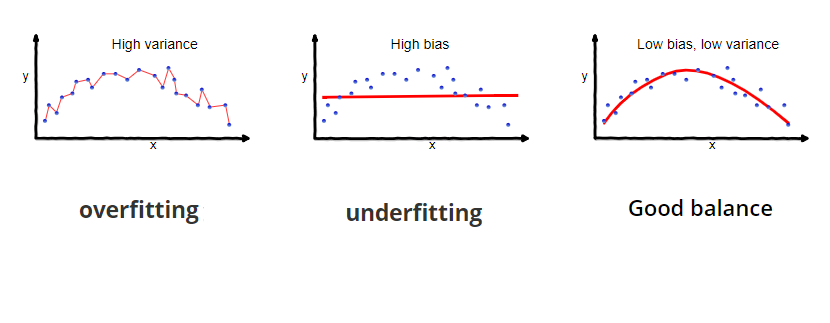

To prevent overfitting, we split our dataset into two components:

* `train_ds`: used for training the model
* `test_ds`: used for testing the model

The validation dataset is **not used at all during training**.

In [ ]:
train_ds = dataset.sample(frac=0.8, random_state=0)
test_ds = dataset.drop(train_ds.index)

#### Separating features and labels

We have features and labels in the same pandas dataframe. Although `model.fit()` supports training on the entire dataframe, it will be easier to separate these for this tutorial.

In [ ]:
train_xs = train_ds.copy()
test_xs = test_ds.copy()

train_y = train_xs.pop('MPG')
test_y = test_xs.pop('MPG')

#### Simple regression model: MPG ~ Horsepower

Let's build a 1D regression model, predicting MPG based on horsepower.

In [ ]:
def build_mpg_horsepower_model():
  model = tf.keras.Sequential([
       tf.keras.layers.Dense(units=1, activation="linear", input_shape=(1,))
  ])
  model.compile(optimizer="adam", loss="mse")
  model.summary()
  return model

model = build_mpg_horsepower_model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Next, we train the model on the dataset. In this case, we also separate a part of the train dataset to be used for **validation** during the training.

In [ ]:
hist = model.fit(train_xs['Horsepower'], train_y, epochs=100, validation_split=0.2)

Epoch 1/100
8/8 [==============================] - 0s 12ms/step - loss: 439.7387 - val_loss: 454.0693
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 412.3988 - val_loss: 428.6342
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 389.5201 - val_loss: 405.0394
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 366.8096 - val_loss: 383.8891
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 347.2299 - val_loss: 364.3275
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 328.4526 - val_loss: 346.8599
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 313.1480 - val_loss: 330.5502
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 297.0535 - val_loss: 316.9268
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 285.0926 - val_loss: 304.1081
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 272.3137 - val_los

We can plot the training and validation losses for each epoch to visualize training efficiency:

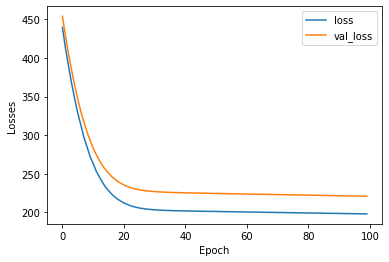

In [ ]:
def plot_training_history(hist, y_max=None):
  plt.plot(hist.history['loss'], label='loss')
  plt.plot(hist.history['val_loss'], label='val_loss')
  if y_max: plt.ylim([0, y_max])
  plt.xlabel('Epoch')
  plt.ylabel('Losses')
  plt.legend()

plot_training_history(hist)

Finally, we evaluate the model on the test dataset:

In [ ]:
test_results = {}  # we collect all evaluation scores here

test_results['mpg_horsepower_model'] = model.evaluate(test_xs['Horsepower'], test_y, verbose=0)
print(test_results)

{'mpg_horsepower_model': 238.733642578125}


### Normalizing dataset columns

If the features and labels of a dataset have different ranges and distribution scales, the model might converge slower, if at all.

Thus, to improve model performance, in this section we use a normalization layer in front of the regression neuron.

Before normalizing, we can check that the features in the data are not normalized:

In [ ]:
train_ds.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


We build a normalized based on the 'Horsepower' column (the only feature we're considering now):

In [ ]:
def build_normalizer(based_on):
  data = np.array(based_on)
  normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[1,])
  normalizer.adapt(data)
  return normalizer

normalizer = build_normalizer(train_xs['Horsepower'])

And then we build the new model:

In [ ]:
def build_normalized_mpg_horsepower_model(normalizer):
  model = tf.keras.Sequential([
      normalizer,
      tf.keras.layers.Dense(1, activation="linear"),
    ])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mse")
  model.summary()
  return model

model = build_normalized_mpg_horsepower_model(normalizer)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


**Note**: Discuss the additional parameters

Like before, we train the model, we plot the loss and we store the validation score:

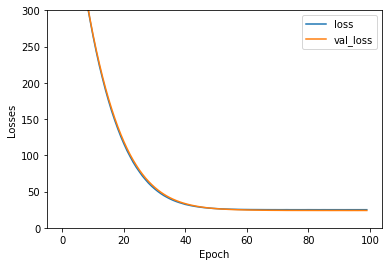

In [ ]:
hist = model.fit(train_xs['Horsepower'], train_y, epochs=100, verbose=0, validation_split=0.2)
plot_training_history(hist, y_max=300)
test_results['normalized_mpg_horsepower_model'] = model.evaluate(test_xs['Horsepower'], test_y, verbose=0)

In [ ]:
test_results

{'mpg_horsepower_model': 238.733642578125,
 'normalized_mpg_horsepower_model': 20.89924430847168}

### Multiple inputs

Now, we try a regression model that uses more features from the data:

We can view all regression problems as matrix multiplications.

In 1D, $ y = wx + b$ can be viewed as:

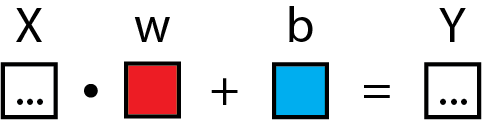

whereas in higher dimensions, $y = wx + b$ is

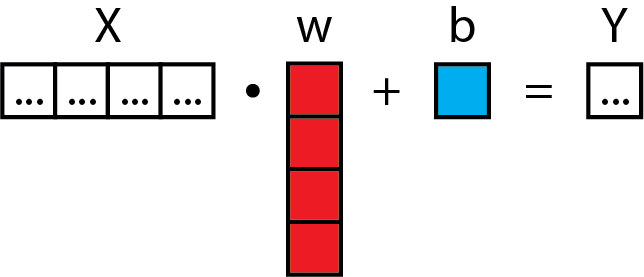

However, the neural net representation of both scenarios is the same:

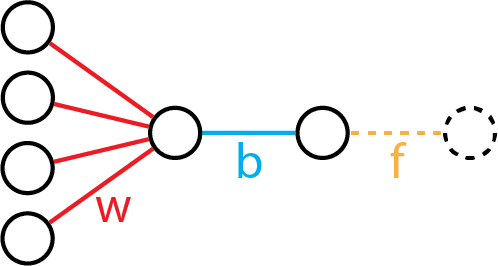

That is, instead of having a single weight for the neuron, we have as many as there are features.

Let's build the model, first with no normalization:

In [ ]:
def build_mpg_nd_model(num_features):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(1, activation="linear", input_shape=(num_features,)),
    ])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mse")
  model.summary()
  return model

model = build_mpg_nd_model(train_xs.shape[1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


**Note**: Discuss number of parameters

Again, we can train the model and evalue it:

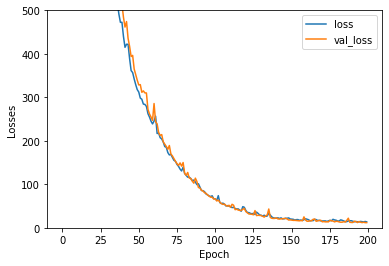

In [ ]:
hist = model.fit(train_xs, train_y, epochs=200, verbose=0, validation_split=0.2)
plot_training_history(hist, y_max=500)
test_results['mpg_nd_model'] = model.evaluate(test_xs, test_y, verbose=0)

In [ ]:
test_results

{'mpg_horsepower_model': 238.733642578125,
 'mpg_nd_model': 8.519569396972656,
 'normalized_mpg_horsepower_model': 20.89924430847168}

### Normalizing the entire dataset

We train the same model as before, but this time we normalize on the entire dataset:

In [ ]:
def build_full_normalizer(based_on):
  data = np.array(based_on)
  normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
  normalizer.adapt(data)
  return normalizer

normalizer = build_full_normalizer(train_xs)

Then the model:

In [ ]:
def build_normalized_mpg_nd_model(normalizer):
  model = tf.keras.Sequential([
      normalizer,
      tf.keras.layers.Dense(1, activation="linear"),
    ])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mse")
  model.summary()
  return model

model = build_normalized_mpg_nd_model(normalizer)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


Train and test:

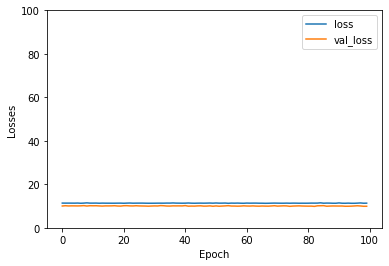

In [ ]:
hist = model.fit(train_xs, train_y, epochs=100, verbose=0, validation_split=0.2)
plot_training_history(hist, y_max=100)
test_results['normalized_mpg_nd_model'] = model.evaluate(test_xs, test_y, verbose=0)

In [ ]:
test_results

{'mpg_horsepower_model': 238.733642578125,
 'mpg_nd_model': 8.519569396972656,
 'normalized_mpg_horsepower_model': 20.89924430847168,
 'normalized_mpg_nd_model': 10.247586250305176}

### A normalized deep neural network

We extend the previous model by adding 2 hidden layers with RELU activation.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_19 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________
6.855825424194336


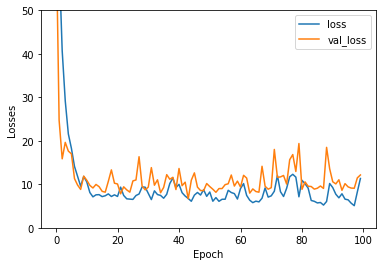

In [ ]:
def build_normalized_mpg_dnn_model(normalizer):
  model = tf.keras.Sequential([
      normalizer,
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(1, activation="linear"),
    ])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mse")
  model.summary()
  return model

model = build_normalized_mpg_dnn_model(normalizer)

hist = model.fit(train_xs, train_y, epochs=100, verbose=0, validation_split=0.2)
plot_training_history(hist, y_max=50)
test_results['normalized_mpg_dnn_model'] = model.evaluate(test_xs, test_y, verbose=0)
print(test_results['normalized_mpg_dnn_model'])

### Validation scores:

Here, we print validation scores for all models built for the MPG problem.

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
mpg_horsepower_model,238.733643
normalized_mpg_horsepower_model,20.899244
mpg_nd_model,8.519569
normalized_mpg_nd_model,10.247586
normalized_mpg_dnn_model,6.855825


In [ ]:
model

In [ ]:
model.save("/tmp/x")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/x/assets


In [ ]:
import os

for g in os.walk("/tmp/x"):
  print(g)

('/tmp/x', ['variables', 'assets'], ['saved_model.pb'])
('/tmp/x/variables', [], ['variables.index', 'variables.data-00000-of-00001'])
('/tmp/x/assets', [], [])


In [ ]:
l = model.get_layer(index=1)

In [ ]:
normalizer.